# Let's see if fractional and even factors 1.5, 2, 2.5 make a difference on the optimized VQE circuit

In [36]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

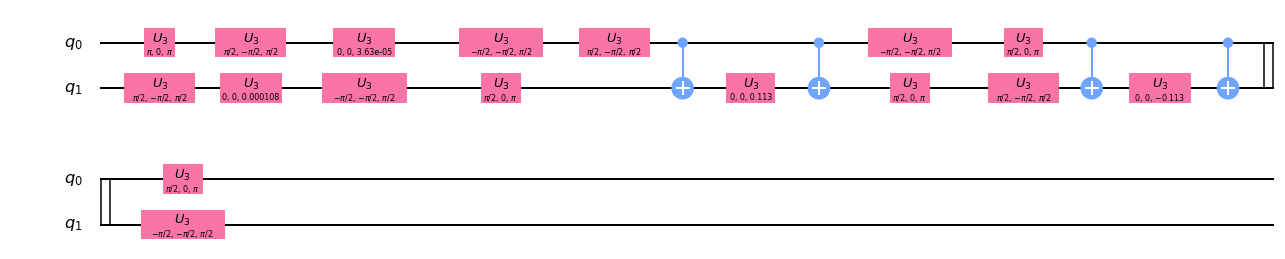

In [37]:
#Optimized Circuit (0.74 ang H2 on qasm sim with no shot noise)
circ_str = """OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nu3(pi,0,pi) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(0,0,3.6279236e-05) q[0];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[1];\nu3(0,0,0.00010816593) q[1];\nu3(-pi/2,-pi/2,pi/2) q[1];\nu3(pi/2,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,0.11268152) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[1];\nu3(pi/2,-pi/2,pi/2) q[1];\ncx q[0],q[1];\nu3(0,0,-0.11268152) q[1];\ncx q[0],q[1];\nu3(pi/2,0,pi) q[0];\nu3(-pi/2,-pi/2,pi/2) q[1];\n"""
circ = QuantumCircuit.from_qasm_str(circ_str)
circ.draw(output = 'mpl')

## Helper Functions

In [38]:
import re
def addCXerrorToH2(circ, c): 
    '''
    Input: Scale factors( a list of 4 component factors) and circuit 
    Output: Circuit with scaled noise
    '''
#     print(circ)
    newqasm_str=""
    qs=circ.qasm()
#     print('starting stringification now')
#     print(qs.splitlines())
#     print('ending stringification now')
#     print('Cant even understand its own stuff')
#     circy=QuantumCircuit().from_qasm_str(qs)
#     print('I am wrong')
    n_cnot = -1
    qregname=circ.qregs[0].name
    for line in iter(qs.splitlines()):
        if line.startswith('cx'):
            n_cnot+=1
            ## Find the number of the control and the target qubit
            search_results = re.finditer(r'\[.*?\]', line)
            count=0
            for item in search_results:
                if count==0:
                    control_ind=int(item.group(0).lstrip('[').rstrip(']'))
                else:
                    target_ind=int(item.group(0).lstrip('[').rstrip(']'))
                count+=1

            newqasm_str+=line+"\n"

            ## increase the error rate of a cx gate
            for i in range(1,c[n_cnot]):
                newqasm_str+="""barrier q[0],q[1];\n"""
                newqasm_str+="cx"+" "+qregname+"["+str(control_ind)+"],"+qregname+"["+str(target_ind)+"];\n"
                newqasm_str+="""barrier q[0],q[1];\n"""
        else:
            newqasm_str+=line+"\n"
#     print('Here is the circuit string:')
#     print(newqasm_str)
    circo=QuantumCircuit().from_qasm_str(newqasm_str)
    
#     print('Adding CX errors done')
    return circo

In [66]:
def generateScaleFactorCombos(component_factors, desired_factor): 
    '''
    Input: List of component factors (must be odd), and desired factor (int)
    Output: List of possible combos for hydrogen molecule VQE circuit (assumes 4 CNOT gates)
    '''
    combos = []
    
    for i in component_factors:
        for j in component_factors:
            for k in component_factors:
                for l in component_factors:
                    if (i+j+k+l)/4 == desired_factor: 
                         combos.append([i,j,k,l])
                    
    return combos
    

In [67]:
1!=2

True

In [72]:
len(generateScaleFactorCombos([1,3,5], ))

16

In [44]:
#Testing at 1.5
circuits = []
combos = generateScaleFactorCombos([1,3,5], 1.5)
for i in combos: 
    circuit = addCXerrorToH2(circ, i)
    circuits.append(circuit)

In [45]:
circuits

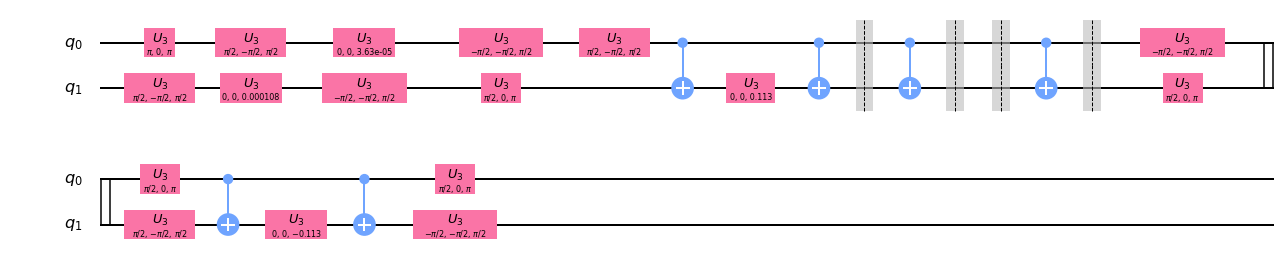

In [46]:
circuits[2].draw(output = 'mpl')

In [47]:
vqe_circ = circ

# Hammification

In [73]:
from qiskit import ClassicalRegister

Hamiltonian = """II
IZ 
ZI
ZZ
XX"""

Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]


circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        
        ##do nothing if Z or I
        if(op == "X"): 
            circ.h(index)
        elif(op == "Y"):
            circ.rx(pi/2, index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

In [74]:
less_circuits = [circuits[0], circuits[4]]

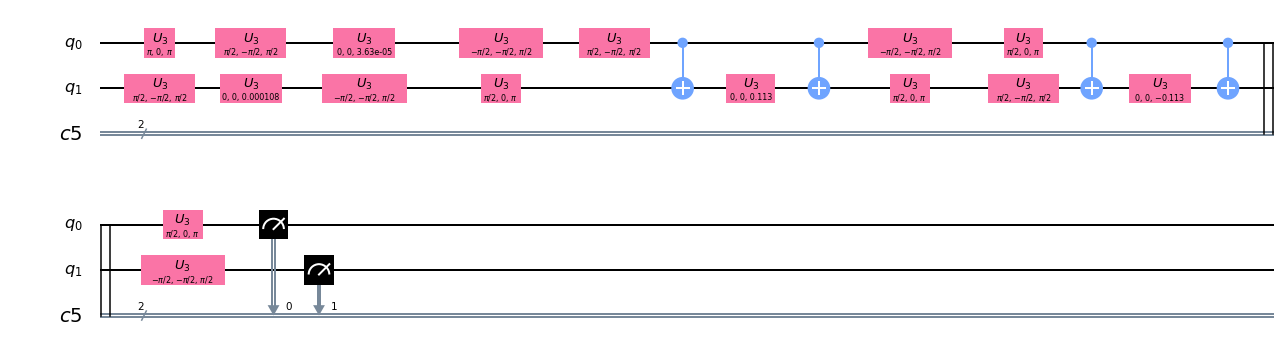

In [75]:
less_circuits[0].draw(output = 'mpl')

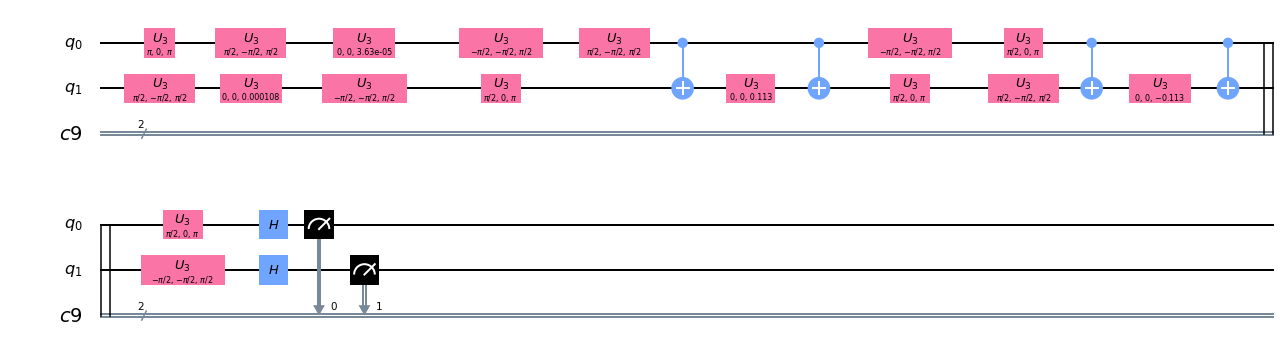

In [76]:
less_circuits[1].draw(output = 'mpl')

## CNOT-ification

In [77]:
lots_scaled_circuits = []
n_samples = 30
scales = [1,1.5,2,2.5,3,3.5,4,4.5,5]

for c in scales:
    scale_circs = []
    print('------------------------------Starting Scale: ' +str(c) + ' ---------------------')
    
    for hammyfied_circ in less_circuits: 
        hammyfied_circs = []
        print( "Starting Hammified Circ")
        for i in range(n_samples):
            combo_circ = []
            circ = hammyfied_circ.copy()
            combos = generateScaleFactorCombos([1,3,5], c)
            for j in combos:
                circy = addCXerrorToH2(circ,j)
                combo_circ.append(circy)
            hammyfied_circs.append(combo_circ)
        scale_circs.append(hammyfied_circs)
    lots_scaled_circuits.append(scale_circs)

------------------------------Starting Scale: 1 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 1.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 2 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 2.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 3 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 3.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 4 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 4.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 5 

In [78]:
#For 1
len(lots_scaled_circuits[0][1])

30

In [79]:
#For 1.5
len(lots_scaled_circuits[1][1])

30

In [80]:
#For 2
len(lots_scaled_circuits[2][1])

30

In [81]:
#For 2.5
len(lots_scaled_circuits[3][1])

30

In [82]:
#For 3
len(lots_scaled_circuits[4][1])

30

In [83]:
lots_scaled_circuits[2][1]

[[<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x27314472fc8>,

# Running Circuits

## Expectation Value

In [84]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [85]:
def get_expec_val_H2(results, h, shots = 6080):
    keys = results[0].get_counts().keys()
    e_val = 0
    for key in keys:
        counts = 0
        for result in results:
            counts+= int(result.get_counts()[key])
        key_val = int(key)
        key_dval = int(binaryToDecimal(key_val))
        
        ## II
        if (h==0):
            e_val += (int(counts)/shots)
        ## IZ
        elif (h==1):
            if (key_dval == 1 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
         ## ZI
        elif (h==2):
            if (key_dval == 2 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
        ## ZZ and XX(measured in ZZ basis)
        elif(h==3 or h==4):
            # 00 and 11 are +1 eigenvalues and others are -1
            if (key_dval == 0 or key_dval == 3):
                e_val += (int(counts)/shots)
            else:
                e_val += (-1)*(int(counts)/shots)
    return e_val
    

## Running 'em on Noisy Simulator first

In [86]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance

provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_london')
noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')
noisy_sim = QuantumInstance(backend = simulator, noise_model = noise_model)

basis_gates = noise_model.basis_gates

In [87]:
from qiskit import execute 
from qiskit.compiler import transpile 
from qiskit.tools.monitor import job_monitor

lots_scaled_results = []
for scale_circs in lots_scaled_circuits:
    print('------------------------------Starting Scale ---------------------')
    scale_results = []
    for hammyfied_circs in scale_circs:
        print( "......................Starting Hammified Circs")
        hammyfied_results = []
        i=0
        for circs in hammyfied_circs: 
            i +=1
            n_combos = len(circs)
            print('---Starting Sample ' + str(i) + ' with ' + str(n_combos) + ' circuits')
            combos_results = []
            for circ in circs:
                circ = transpile(circ, basis_gates = basis_gates)
                job =  execute(circ, backend = simulator, noise_model = noise_model, shots = int(6080/n_combos))
                job_monitor(job)
                result = job.result()
                combos_results.append(result)
            hammyfied_results.append(combos_results)
        scale_results.append(hammyfied_results)
    lots_scaled_results.append(scale_results)

------------------------------Starting Scale ---------------------
......................Starting Hammified Circs
---Starting Sample 1 with 1 circuits
Job Status: job has successfully run
---Starting Sample 2 with 1 circuits
Job Status: job has successfully run
---Starting Sample 3 with 1 circuits
Job Status: job has successfully run
---Starting Sample 4 with 1 circuits
Job Status: job has successfully run
---Starting Sample 5 with 1 circuits
Job Status: job has successfully run
---Starting Sample 6 with 1 circuits
Job Status: job has successfully run
---Starting Sample 7 with 1 circuits
Job Status: job has successfully run
---Starting Sample 8 with 1 circuits
Job Status: job has successfully run
---Starting Sample 9 with 1 circuits
Job Status: job has successfully run
---Starting Sample 10 with 1 circuits
Job Status: job has successfully run
---Starting Sample 11 with 1 circuits
Job Status: job has successfully run
---Starting Sample 12 with 1 circuits
Job Status: job has successfully

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 20 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 21 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 22 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 23 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 24 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully 

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 2 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 3 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 4 with 10 circuits
Job Status: job has successfully ru

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 22 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 23 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 24 with 10 circuits
Job Status: job has successfully

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 12 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 13 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 14 with 10 circ

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 2 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 15 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 28 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 11 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 24 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 6 with 19 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 17 with 19 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 28 with 19 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 9 with 19 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 20 with 19 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
------------------------------Starting Scale ---------------------
......................Starting Hammified Circs
---Starting Sample 1 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully r

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 13 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 14 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully r

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 26 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 27 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully r

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 9 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 10 with 16 circuit

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 22 with 16 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run

Job Status: job has successfully run
---Starting Sample 6 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 7 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 8 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully ru

Job Status: job has successfully run
---Starting Sample 26 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 27 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 28 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully

Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 16 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 17 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 18 with 10 circuits
Job Status: job has successfully run
Job Status: job has successfully

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 12 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 13 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 14 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 15 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 16 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully 

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 26 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 27 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 28 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 29 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
---Starting Sample 30 with 4 circuits
Job Status: job has successfully run
Job Status: job has successfully 

In [88]:
#Expectation Value
lots_scaled_values = []

for scale_results in lots_scaled_results: 
    scale_values = []
    n = 5 #if 5 hammys, then length is 5
    for i in range(n): 
        hammyfied_vals = []
        if (i <4):
            c = 0
        else: 
            c= 1
        for combo_results in scale_results[c]: 
            n_combo = len(combo_results)
            print(n_combo)
            hammyfied_val = get_expec_val_H2(combo_results, i)
            hammyfied_vals.append(hammyfied_val)
        scale_values.append(hammyfied_vals)
    lots_scaled_values.append(scale_values)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

In [89]:
shift = 0.7151043390810812

lots_scaled_expec_vals = []
for scale_values in lots_scaled_values:
    scale_expec_vals = []
    for s in range(n_samples):
        exp_val = 0
        for h in range(len(Hamiltonian_weights)):
            exp_val += (Hamiltonian_weights[h])*(scale_values[h][s])
        #adding in shift (nuclear attraction energy)
        exp_val+=shift
        scale_expec_vals.append(exp_val)
    lots_scaled_expec_vals.append(scale_expec_vals)

In [90]:
import numpy as np
#Finding means 
means = []
std_devs = []
errs_on_mean = []
for scale_expec_vals in lots_scaled_expec_vals:
    mean = np.mean(scale_expec_vals)
    means.append(mean)
    std = np.std(scale_expec_vals)
    std_devs.append(std)
    err = std/np.sqrt(n_samples)
    errs_on_mean.append(err)

In [91]:
means

[-0.9989966587259363,
 -0.965422853901375,
 -0.9328546631119011,
 -0.8990309679364626,
 -0.8714020205680415,
 -0.8444219986382169,
 -0.817100671883831,
 -0.7887104306557611,
 -0.7666900578487433]

In [92]:
std_devs

[0.004838028422710366,
 0.004714001604983831,
 0.005512678320223139,
 0.0056941817393788,
 0.005108306863597417,
 0.006046784933562664,
 0.006932620580876163,
 0.005866900330403225,
 0.007421421463147699]

In [93]:
errs_on_mean

[0.0008832991003232022,
 0.0008606550050550673,
 0.0010064727560853003,
 0.0010396105950639238,
 0.0009326449666169236,
 0.0011039868361648827,
 0.001265717558256814,
 0.0010711445511987863,
 0.0013549599813729965]

In [ ]:
means = [-1.05954143999878,
 -1.0454676769779467,
 -1.0285906478980855,
 -1.0137001639571133,
 -1.0013431435578075]

In [ ]:
std_devs = [0.004401671416208019,
 0.0053076151788622895,
 0.004179338662658817,
 0.006034773557566771,
 0.005340444905973335]

In [ ]:
errs_on_mean = [0.0008036315751276142,
 0.0009690335200065643,
 0.0007630393536639026,
 0.001101793868971674,
 0.0009750273807050504]

In [ ]:
scales = [1,1.5,2,2.5,3]

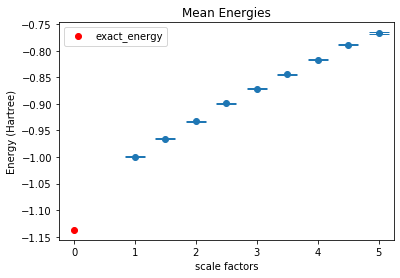

In [95]:
import matplotlib.pyplot as plt
#Plotting the results 
vqe_mean = means
vqe_std = std_devs
vqe_err  = errs_on_mean

#Plotting means 
plt.figure()
plt.errorbar(scales, vqe_mean, yerr=vqe_err,capsize = 10, fmt ='o' )
plt.plot(0, -1.137, 'ro', label = 'exact_energy')

plt.title('Mean Energies')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

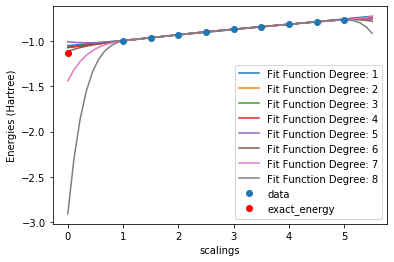

In [101]:
#Polynomial Curve Fitting (4th order)
import matplotlib.pyplot as plt
import numpy as np

funcs = []
n_degree = 8
for i in range(1,n_degree+1): 
    param= np.polyfit(scales, vqe_mean, i, w=[1/j for j in vqe_std])
    p = np.poly1d(param)
    funcs.append(p)
    
#Plotting 
x = np.linspace(0, 5.5, 50)
for p in funcs: 
    plt.plot(x, p(x), label='Fit Function Degree: ' + str(p.order))
plt.plot(scales, vqe_mean, marker = 'o', linestyle = ' ', color = 'tab:blue',label='data')
plt.plot(0, -1.137, 'ro', label = 'exact_energy')
plt.xlabel('scalings')
plt.ylabel('Energies (Hartree)')
plt.legend()
plt.show()

# Zero Noise Extrapolation

In [102]:
def RichardsonExtrap_Fraction(energies): 
    """
    Input: An array of energies scaled with different stretch factors--normal integer multiples only --eg 1,2,3,4..
    Assumption: Odd scalings - 1,3,5,7,...
    Output: Zero Error extrapolated answer
    """
    n = len(energies)
    scales = [1+i*0.5 for i in range(n)]
    
    #setting up all equations 
    equations = []
    for eq_num in scales: 
        equation = []
        if eq_num == 1: 
            for i in range(n): 
                equation.append(1)
            equations = [equation]
        else: 
            for term_num in scales: 
                term = term_num**(eq_num*2-2)
                #print(term)
                equation.append(term)
            equations = np.append(equations, [equation], axis = 0)
    #print(equations)
    
    #Now filling up equals to matrix 
    equals_to = [1]
    for i in range(1, n): 
        equals_to.append(0)
    #print(equals_to)
    
    #solving the system
    coeff = np.linalg.solve(equations, equals_to)
    #print(coeff)
    
    #Combine coeff with energies to get zero noise result 
    result = np.dot(coeff, energies)
    return result

# Monte Carlo for fractional factors
1,1.5,...

In [103]:
def MonteCarloError(means, std_devs, poly_fit = False, deg = 1, sampling_size = 1000): 
    """
    Input: arrays means and standard deviations of the various scalings of noise, whether to do richardson i.e. no poly fit 
    If doing polyfit, then specify degree, sampling_size is how many times to sample from the Gaussian 
    
    Assumption: Scaled by integer values ranging from 1 to X where X>1
    
    Output: Error estimate
    """
    n = len(means)
    
    #Sampling from Gaussian for each scaling 
    all_samples = []
    debug_means = []
    for i in range(n): 
        samples = np.random.normal(means[i], std_devs[i], sampling_size)
        all_samples.append(samples)
        #for debugging
        debug_means.append(means[i] - np.mean(samples))
    #print(debug_means)
    
    #Doing Extrapolation for all sampling_size samples (1000 if set to default)
    zero_noise_energies = []
    for j in range(sampling_size): 
        energies = []
        for i in range(n): 
            energies.append(all_samples[i][j])
            
        ##Doing either richardson or funcs 
        ###Polynomial
        if poly_fit: 
            ####need the scale values: 
            scales = []
            scales = [0.5*c +1 for c in range(n)]
            ####making the function 
            param = np.polyfit(scales, energies, deg, w = [1/i for i in std_devs])
            f = np.poly1d(param)
            ####extrapolation
            result = f(0)
            zero_noise_energies.append(result)
            
        ###Richardson
        else: 
            result = RichardsonExtrap_Fraction(energies)
            zero_noise_energies.append(result)
    
    #Returning error i.e. std 
    error = np.std(zero_noise_energies)
    return error
    
        

In [104]:
#Richardson Extrap Error(Uncertainity)
R_uncert = MonteCarloError(vqe_mean, vqe_std, poly_fit = False)

#Polynomial Fits Errors (Uncertainities)
poly_uncerts = []
for i in range(1, n_degree+1): 
    uncert = MonteCarloError(vqe_mean, vqe_std, poly_fit = True, deg = i)
    poly_uncerts.append(uncert)

In [105]:
R_uncert

10.105324716904956

In [106]:
poly_uncerts

[0.004417427309945373,
 0.009613585727548493,
 0.022927673184681925,
 0.05413834129683111,
 0.15423165934545585,
 0.4831211288130999,
 1.881128588469467,
 9.93789880076551]

In [107]:
funcs

[poly1d([ 0.0589847 , -1.05277254]),
 poly1d([-0.00281814,  0.07516324, -1.07143963]),
 poly1d([ 1.05043638e-04, -3.73884260e-03,  7.75494421e-02, -1.07318461e+00]),
 poly1d([ 8.77654232e-06,  1.81605727e-06, -3.31856247e-03,  7.68614099e-02,
        -1.07281142e+00]),
 poly1d([-5.69332582e-04,  8.47199865e-03, -4.73700027e-02,  1.20023325e-01,
        -7.05683709e-02, -1.00886435e+00]),
 poly1d([-3.52437468e-04,  5.73277185e-03, -3.63476605e-02,  1.13815653e-01,
        -1.86805457e-01,  2.20167660e-01, -1.11517777e+00]),
 poly1d([ 3.88523975e-04, -8.47406160e-03,  7.58730951e-02, -3.59417506e-01,
         9.66993020e-01, -1.47204792e+00,  1.23724892e+00, -1.43955523e+00]),
 poly1d([-6.10445280e-04,  1.50070343e-02, -1.57237205e-01,  9.13918431e-01,
        -3.20951020e+00,  6.93920986e+00, -8.97430710e+00,  6.38149005e+00,
        -2.90695708e+00])]

In [108]:
#Richardson 
R_zero = RichardsonExtrap_Fraction(vqe_mean)

##Finding zero_noise
poly_zero = []
for f in funcs:
    poly_zero.append(f(0))

In [109]:
R_zero

-2.9069570760478882

In [110]:
poly_zero

[-1.0527725389959914,
 -1.0714396336654957,
 -1.0731846074136644,
 -1.072811417533087,
 -1.0088643495496732,
 -1.115177773713389,
 -1.4395552309224537,
 -2.9069570753130587]

In [111]:
exact_energy = -1.137

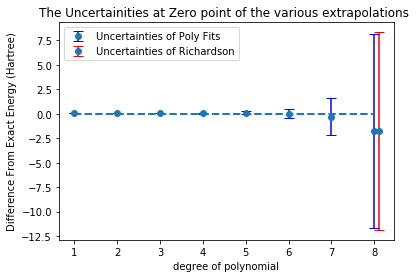

In [112]:
exact_energy = [exact_energy]
import matplotlib.pyplot as plt 
degrees = []
for i in range(n_degree): 
    degrees.append(i+1)
plt.errorbar(degrees, [energy - exact_energy[0] for energy in poly_zero], yerr=poly_uncerts, capsize = 5,fmt ='o', ecolor = 'blue', label = 'Uncertainties of Poly Fits' )
plt.errorbar(n_degree+.1, R_zero- exact_energy[0], yerr=R_uncert, capsize = 5,fmt ='o', ecolor = 'red' , label = 'Uncertainties of Richardson')
plt.plot()
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('The Uncertainities at Zero point of the various extrapolations ')
plt.plot(degrees, [0*i for i in range(len(degrees))], linestyle = '--', linewidth = 2)
plt.legend()
plt.show()

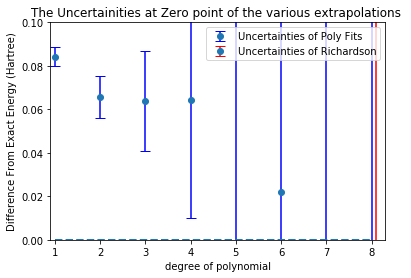

In [114]:
plt.errorbar(degrees, [energy - exact_energy[0] for energy in poly_zero], yerr=poly_uncerts, capsize = 5,fmt ='o', ecolor = 'blue', label = 'Uncertainties of Poly Fits' )
plt.errorbar(n_degree+.1, R_zero- exact_energy[0], yerr=R_uncert, capsize = 5,fmt ='o', ecolor = 'red' , label = 'Uncertainties of Richardson')
plt.axis([.9, 8.3, 0, 0.1])
plt.xlabel('degree of polynomial')
plt.ylabel('Difference From Exact Energy (Hartree)')
plt.title('The Uncertainities at Zero point of the various extrapolations ')
plt.plot(degrees, [0*i for i in range(len(degrees))], linestyle = '--', linewidth = 2)
plt.legend()
plt.show()

In [115]:
vqe_mean

[-0.9989966587259363,
 -0.965422853901375,
 -0.9328546631119011,
 -0.8990309679364626,
 -0.8714020205680415,
 -0.8444219986382169,
 -0.817100671883831,
 -0.7887104306557611,
 -0.7666900578487433]